<a href="https://colab.research.google.com/github/pranavrelds/scania-APS-Failure-Prediction/blob/main/Scania_Trucks_Air_Pressure_System_Failure_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [86]:
! pip install feature-engine

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, RecursiveFeatureElimination

# Configurations

In [16]:
DIR = '/content/drive/MyDrive/Scania Trucks APS Failure Prediction/'
DF_TRAIN = pd.read_csv(DIR+'aps_failure_training_set.csv')
DF_TRAIN.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0


# Exploratory Data Analysis

In [17]:
print("Total number of Train datapoints: ",DF_TRAIN.shape[0])
print("Total number of features: ",DF_TRAIN.shape[1])

Total number of Train datapoints:  60000
Total number of features:  171


## Changing the Class label

In [18]:
# Converting the Class label to 
# neg = 0
# pos = 1
DF_TRAIN['class'] = DF_TRAIN['class'].map({'neg' : 0, 'pos' : 1})
DF_TRAIN.head(2)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0


## Class Label Distribution

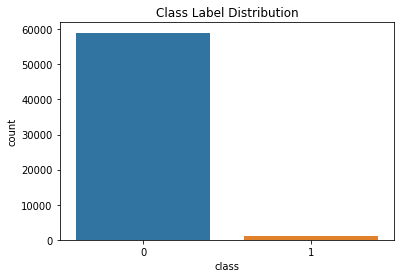

The number of positive class points is:  1000
The number of negative class points is:  59000


In [22]:
sns.countplot(DF_TRAIN['class'])
plt.title('Class Label Distribution')
plt.show()
print('The number of positive class points is: ',DF_TRAIN['class'].value_counts()[1])
print('The number of negative class points is: ',DF_TRAIN['class'].value_counts()[0])
plt.show()

**Observation:**

This dataset is **highly imbalanced** as the number of negative class points are much much more than the positive class points. 

## Checking the Data Type 

In [ ]:
DF_TRAIN.dtypes

class      int64
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
           ...  
ee_007    object
ee_008    object
ee_009    object
ef_000    object
eg_000    object
Length: 171, dtype: object

In [23]:
# Replacing 'na' with np.nan
DF_TRAIN = DF_TRAIN.replace('na', np.nan)

# Converting the data to numeric form for further processing
DF_TRAIN = DF_TRAIN.apply(pd.to_numeric)
DF_TRAIN.dtypes

class       int64
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

## Checking the Missing Values

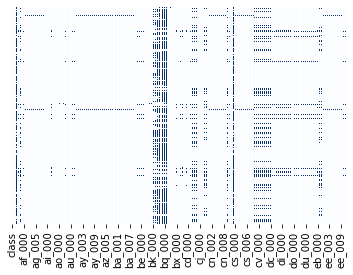

In [ ]:
# Heatmap showing missing values
sns.heatmap(DF_TRAIN.isnull(), cbar=False, yticklabels=False, cmap='Blues')

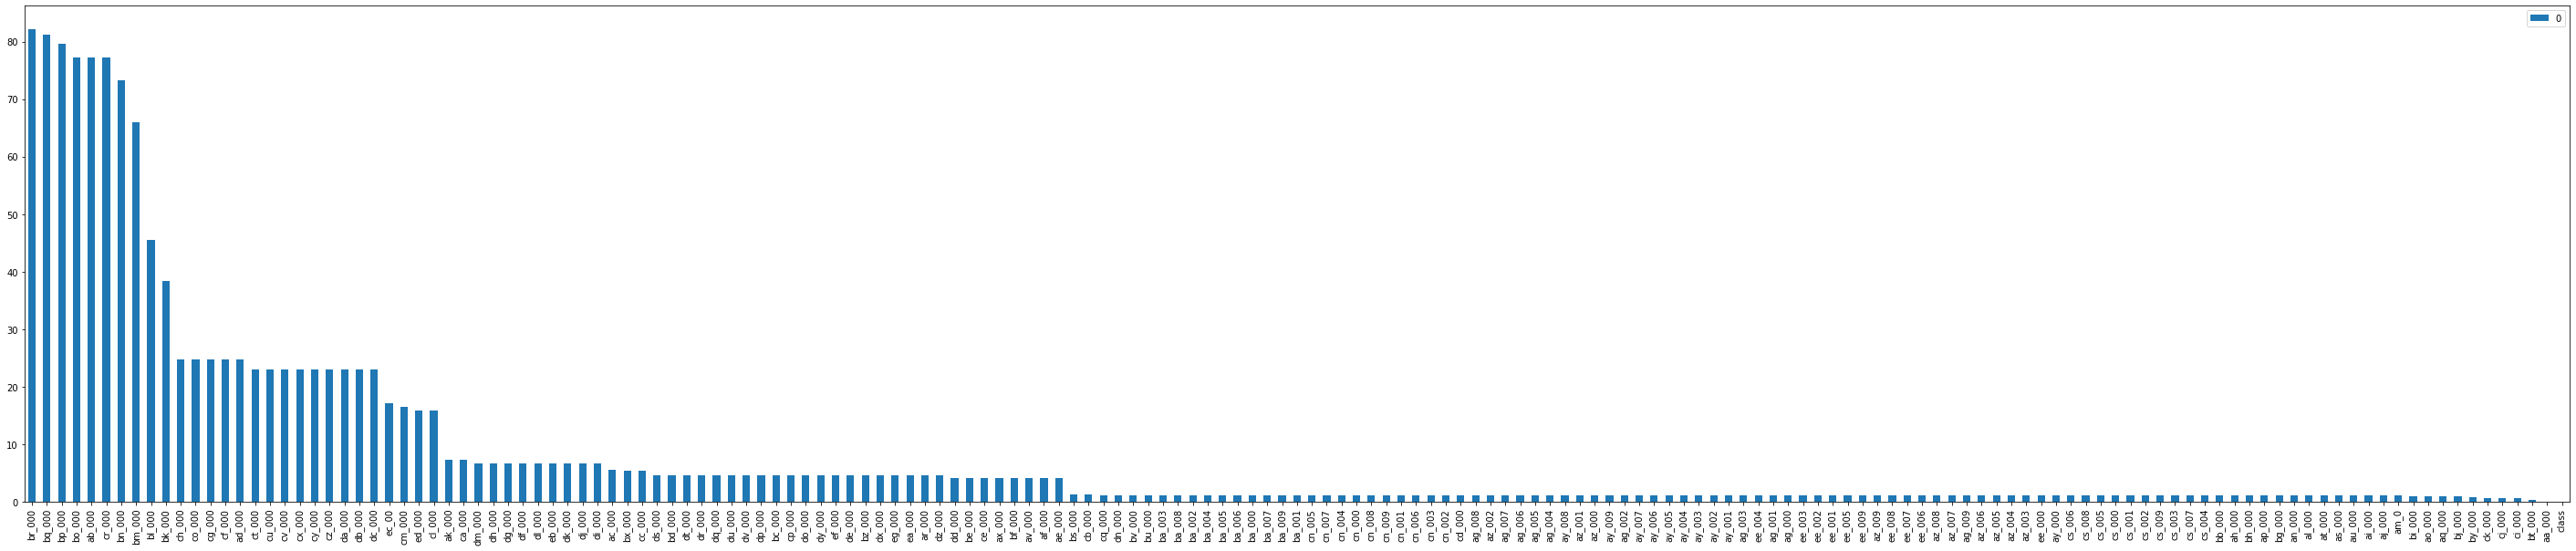

In [26]:
# Percent of missing data in features
missing = DF_TRAIN.isna().sum().div(DF_TRAIN.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing.plot.bar(figsize=(50,10))
plt.show()

**Observation:**

Dataset have **significant** amount of missing data. Some features have more tha 80% missing values

### Removing the features having more than 60% missing data

In [27]:
# Features with more than 60% missing values
columns_missing = missing[missing[0]>60]
columns_missing

,0
br_000,82.106667
bq_000,81.203333
bp_000,79.566667
bo_000,77.221667
ab_000,77.215000
cr_000,77.215000
bn_000,73.348333
bm_000,65.915000


In [28]:
# Removing the features having more than 60 % missing values
DF_TRAIN_60_percent_missing_dropped = DF_TRAIN[DF_TRAIN.columns[DF_TRAIN.isnull().mean() < 0.6]]

print('Old shape of the data : ',DF_TRAIN.shape)
print('New shape of the data after dropping the features having more than 60% missing values', DF_TRAIN_60_percent_missing_dropped.shape)

Old shape of the data :  (60000, 171)
New shape of the data after dropping the features having more than 60% missing values (60000, 163)


## Missing Data Imputation using KNN Imputer

In [36]:
# Seperating the class label 
X = DF_TRAIN_60_percent_missing_dropped.drop(['class'], axis=1)
y = DF_TRAIN_60_percent_missing_dropped['class'] #  Label to predict

print('The shape of X : ',X.shape)
print('The shape of y : ',y.shape)

The shape of X :  (60000, 162)
The shape of y :  (60000,)


In [38]:
# Imputation of missing values in train data using KNN imputer from Scikit learn
# Alternatively MICE (Multivariate Imputation by Chained Equations) can be used to impute the data

imputer_knn = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer_knn.fit(X)
X_imputed = imputer_knn.transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Saving imputed data
DF_TRAIN_imputed_knn = X_imputed.copy()
# Adding labels to the dataframe for saving
DF_TRAIN_imputed_knn['class'] = y
DF_TRAIN_imputed_knn.to_csv(DIR+'DF_TRAIN_imputed_knn.csv', index = False)

## Finding the Histogram and Numeric features
as mentioned in the [datasource](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks), the data is a combination of histogram features and numeric features. The actual feature names are anonymized for proprietary reasons.

In [31]:
# Find histogram and Numeric features
def get_histogram_identifiers(df):
    identifier = []
    for column in df.drop('class', axis=1).columns:
        identifier.append(column.split('_')[0])
        c = Counter(identifier)
    return list(c.keys()), list(c.values())

In [32]:
# Identifier and Bin id for the histogram features
identifier, bin_id = get_histogram_identifiers(DF_TRAIN)

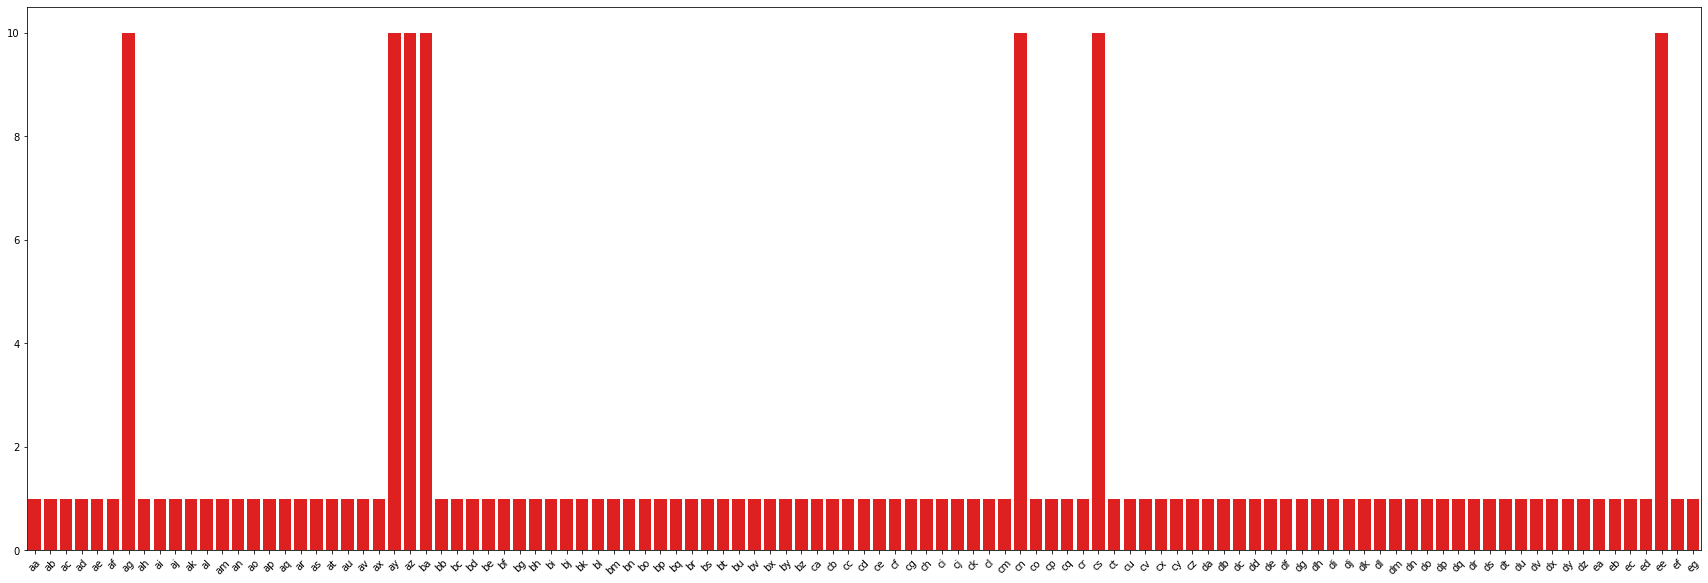

In [33]:
# Plot histogram bins
plt.figure(figsize=(30,10))
sns.barplot(x= identifier, y= bin_id, color='red')
plt.xticks(rotation=45)
plt.show()

In [44]:
# Get Histogram Labels
histogram_labels = []
for key,value in enumerate(bin_id):
    if value == 10:
        histogram_labels.append(identifier[key])

# Columns with Histogram features
columns_with_histogram_features = []
columns_with_histogram_features = [column for column in X_imputed.columns if column.split('_')[0] in histogram_labels]
columns_with_histogram_features

['ag_000',
 'ag_001',
 'ag_002',
 'ag_003',
 'ag_004',
 'ag_005',
 'ag_006',
 'ag_007',
 'ag_008',
 'ag_009',
 'ay_000',
 'ay_001',
 'ay_002',
 'ay_003',
 'ay_004',
 'ay_005',
 'ay_006',
 'ay_007',
 'ay_008',
 'ay_009',
 'az_000',
 'az_001',
 'az_002',
 'az_003',
 'az_004',
 'az_005',
 'az_006',
 'az_007',
 'az_008',
 'az_009',
 'ba_000',
 'ba_001',
 'ba_002',
 'ba_003',
 'ba_004',
 'ba_005',
 'ba_006',
 'ba_007',
 'ba_008',
 'ba_009',
 'cn_000',
 'cn_001',
 'cn_002',
 'cn_003',
 'cn_004',
 'cn_005',
 'cn_006',
 'cn_007',
 'cn_008',
 'cn_009',
 'cs_000',
 'cs_001',
 'cs_002',
 'cs_003',
 'cs_004',
 'cs_005',
 'cs_006',
 'cs_007',
 'cs_008',
 'cs_009',
 'ee_000',
 'ee_001',
 'ee_002',
 'ee_003',
 'ee_004',
 'ee_005',
 'ee_006',
 'ee_007',
 'ee_008',
 'ee_009']

# Feature Selection


1.   Remove Constant features (Features with zero standard deviation)
2.   Removing duplicated features 
3.   Removing correlated features 
4.   Feature selection using PCA (Recursive feature elimination could also be used) 

## Remove Constant & Quasi-Constant Features

In [50]:
constant_features = [feat for feat in X_imputed.columns if X_imputed[feat].std() == 0]
X_imputed.drop(labels=constant_features, axis=1, inplace=True)
constant_features

['cd_000']

In [53]:
# remove quasi-constant features
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(X_imputed)

VarianceThreshold(threshold=0.01)

In [56]:
quasi_constant = X_imputed.columns[~sel.get_support()]
print('Number of quasi-constant features : ',len(quasi_constant))

Number of quasi-constant features :  1


In [ ]:
# Quasi constant feature name 
quasi_constant

Index(['ch_000'], dtype='object')

In [ ]:
# percentage of different values of the feature
X_imputed['ch_000'].value_counts() / np.float(len(X_imputed))

0.0    0.999783
2.0    0.000167
0.4    0.000050
Name: ch_000, dtype: float64

In [57]:
feat_names = X_imputed.columns[sel.get_support()]

In [ ]:
# Transforming the data
X_imputed = sel.transform(X_imputed)

# trasnform the array into a dataframe, as the output of VarianceThreshold is an array
X_imputed = pd.DataFrame(X_imputed, columns=feat_names)
test_df_imputed = pd.DataFrame(test_df_imputed, columns=feat_names)

## Removing Duplicated Features

In [ ]:
# Checking for duplicate features
sel_duplicate = DropDuplicateFeatures( missing_values='raise')
sel_duplicate.fit(X_imputed)

DropDuplicateFeatures(missing_values='raise',
                      variables=['aa_000', 'ac_000', 'ad_000', 'ae_000',
                                 'af_000', 'ag_000', 'ag_001', 'ag_002',
                                 'ag_003', 'ag_004', 'ag_005', 'ag_006',
                                 'ag_007', 'ag_008', 'ag_009', 'ah_000',
                                 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0',
                                 'an_000', 'ao_000', 'ap_000', 'aq_000',
                                 'ar_000', 'as_000', 'at_000', 'au_000',
                                 'av_000', ...])

In [ ]:
print('Number of duplicate features are : ', len(sel_duplicate.features_to_drop_))

Number of duplicate features are :  0


## Removing Correlated Features

In [58]:
# Finding correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_imputed, 0.8)
print('Number of correlated features: ', len(set(corr_features)) )

Number of correlated features:  62


In [59]:
# Removing the correlated features
X_imputed.drop(labels= corr_features, axis=1, inplace= True)

In [60]:
print('The number of features in training data : ', X_imputed.shape[1] )

The number of features in training data :  99


In [63]:
# Standardize the values
scaler = StandardScaler()
scaler.fit(X_imputed)
X_train_scaled = scaler.transform(X_imputed) #without split

# Converting StnadardScaler output back to Pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_imputed.index, columns=X_imputed.columns)

In [79]:
# Balancing the  training dataset 
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_sample(X_train_scaled, y)

In [81]:
X_train_balanced = pd.DataFrame(X_train_balanced,  columns=X_train_scaled.columns)
y_train_balanced = pd.DataFrame(y_train_balanced, columns=['class'])

# Concatinate dataframe
balanced_df = pd.concat([X_train_balanced, y_train_balanced], axis=1)

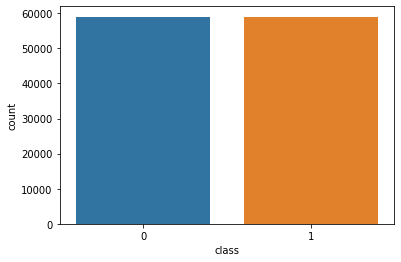

In [85]:
# Checking the class distribution after balancing the data
sns.countplot(balanced_df['class'])

## PCA

In [ ]:
pca = PCA()
pca.fit(X_train_balanced)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

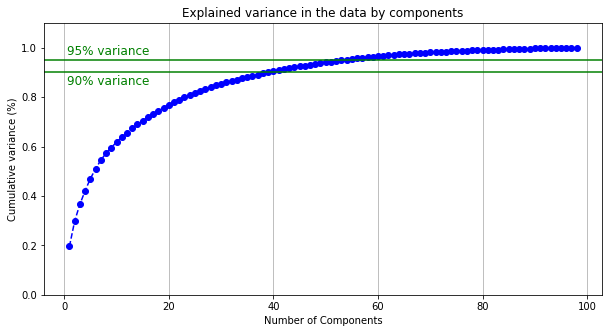

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
xi = np.arange(1, 99, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance in the data by components')
plt.axhline(y=0.90, color='g', linestyle='-')
plt.text(0.5, 0.85, '90% variance', color = 'green', fontsize=12)
plt.axhline(y= 0.95, color='g', linestyle='-')
plt.text(0.5, 0.97, '95% variance', color = 'green', fontsize=12)
ax.grid(axis='x')
plt.show()

**Observation:**

From above graph, around 50 features are required to explain the 95% variance of the data and almost 98 features to completely explain the variance